# DeepONet Tutorial in JAX

A DeepONet is a deep learning architecture to evaluate a *nonlinear operator*
applied to a discretized input field/function at an arbitrary query point. This
can, for instance, be used to learn solutions to a family of parametric PDEs
which can then be queried at arbitrary points in space (and time).

Examples of operator mappings:

* From initial condition to solution field at a later time
* From the parameter field (e.g. space-dependent diffusion coefficient) to the
  solution field

The DeepONet does not return the full output field, but allows us to query it at
arbitrary points.

Following the tutorial of
[DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html),
this video is concered with **learning the 1d antiderivative operator**, defined by the ODE

$$
\begin{cases}
\frac{d v}{d x} &= u(x) \quad & x \in [0, 1]
\\
v(0) &= 0
\end{cases}
$$

For this, we discretize the domain $\Omega = [0, 1]$ into $m=100$ degrees of
freedom at which we evaluate $u(x)$. Then, the DeepONet $G_\theta$ takes this
$100$-dimensional vector and a one-dimensional query coordinate to evaluate
$v(x)$ at this query point.

$$
\begin{aligned}
G_\theta : \R^m \times \R^1 \mapsto \R
\end{aligned}
$$

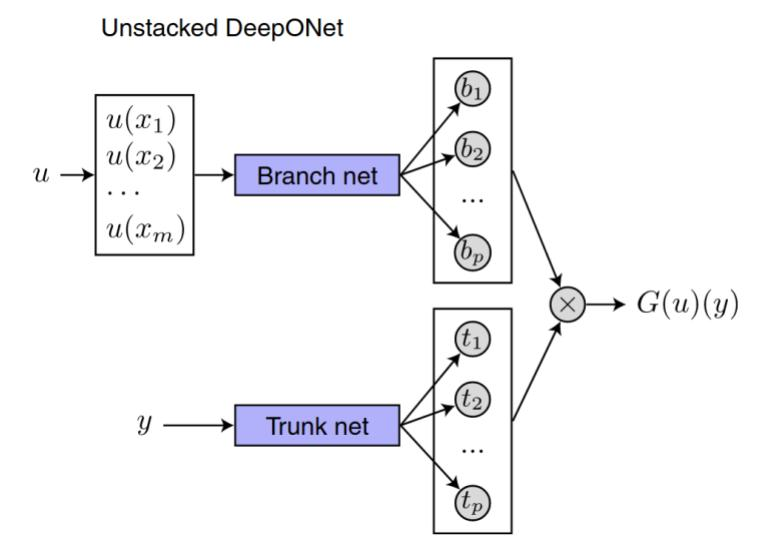

**Branch net** and **Trunk net** are multi-layer perceptrons (MLPs), oftentimes with similar architectures.

The query coordinates do not have to coincide with the coordinates of the
degrees of freedom. For the training of the network, however, we will assume
this. In the terminology of DeepONet and the DeepXDE library, this is called an
**aligned dataset**.

**JAX-related notes**:

Contrary to PyTorch and TensorFlow, we will follow the
[Equinox](https://github.com/patrick-kidger/equinox) convention in that **the
network design is single batch**. Additionaly, it shall take the branch inputs and the trunk
inputs as two separate arguments. Then, we can:

* Vectorize over multiple query points using `jax.vmap(..., in_axes=(None, 0))`
    to get a mapping $\R^m \times \R^{q \times 1} \mapsto \R^q$
* Vectorize over multiple batches (evaluated at the same query point) using
    `jax.vmap(..., in_axes=(0, None))` to get a mapping $\R^{N \times m} \times
    \R \mapsto \R^N$
* Vectorize over both multiple batches and multiple query points using
    `jax.vmap(jax.vmap(..., in_axes=(None, 0)), in_axes=(0, None))` to get a
    mapping $\R^{N \times m} \times \R^{q \times 1} \mapsto \R^{N \times q}$ (which we
    will use during training)

**Training the DeepONet**

Given a dataset of $N$ samples with branch inputs $\R^{N \times m}$, trunk
inputs $\R^{q \times 1}$ and corresponding outputs $\R^{N \times q}$ we compute the loss
as a **mean squared error**. For simplicity, we will use **full-batch training**
(no stochastic minibatching). Everything else, is the classical deep learning
pipeline.

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [3]:
# The dataset is curtesy of the DeepXDE library (Lu et al.), was used in a
# tutorial similar in scope to this notebook
# https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html
# Download from a github repository of ETH Zurich's course on "Deep Learning in
# Scienfitic Computing"
!wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
!wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

--2024-03-16 13:15:01--  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz [following]
--2024-03-16 13:15:01--  https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241573 (236K) [application/octet-stream]
Saving to: ‘antiderivative_aligned_train.npz’

antiderivative_alig 100%[==

In [4]:
dataset_train = jnp.load("antiderivative_aligned_train.npz", allow_pickle=True)
branch_inputs_train = dataset_train["X"][0]
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"]

In [5]:
branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape

((150, 100), (100, 1), (150, 100))

In [6]:
dataset_test = jnp.load("antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0]
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"]

In [7]:
branch_inputs_test.shape, trunk_inputs_test.shape, outputs_test.shape

((1000, 100), (100, 1), (1000, 100))

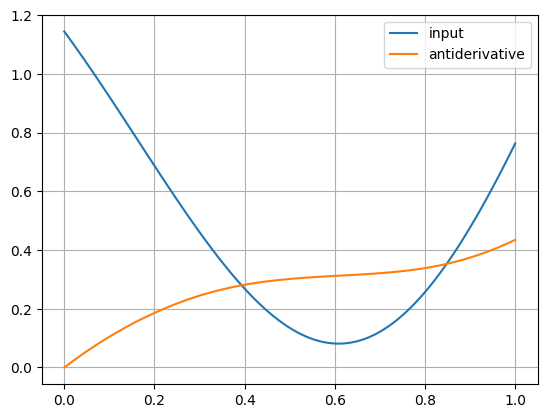

In [10]:
# Due to the dataset being aligned, we can use the trunk inputs as a grid
plt.plot(
    trunk_inputs_train[:, 0],
    branch_inputs_train[2, :],
    label="input",
)
plt.plot(
    trunk_inputs_train[:, 0],
    outputs_train[2, :],
    label="antiderivative",
)
plt.legend()
plt.grid()

In [11]:
class DeepONet1d(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self,
        in_size_branch,
        width_size,
        depth,
        interact_size,
        activation,
        *,
        key,
    ):
        """
        For simplicity, branch and trunk MLP are configured similarly
        """
        b_key, t_key = jr.split(key)
        self.branch_net = eqx.nn.MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=b_key,
        )
        self.trunk_net = eqx.nn.MLP(
            in_size=1,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            final_activation=activation,
            key=t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]

In [14]:
antiderivative_operator = DeepONet1d(
    in_size_branch=100,
    width_size=40,
    depth=1,
    interact_size=40,
    activation=jax.nn.relu,
    key=jr.PRNGKey(0),
)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(
    eqx.filter(antiderivative_operator, eqx.is_array)
)

def loss_fn(model):
    # Full batch training

    # Vectorize over both the batches/samples and the query points
    predictions = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0),
        ),
        in_axes=(0, None)
    )(branch_inputs_train, trunk_inputs_train)

    mse = jnp.mean(jnp.square(predictions - outputs_train))
    return mse

@eqx.filter_jit
def update_fn(model, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []
for _ in tqdm(range(10_000)):
    antiderivative_operator, opt_state, loss = update_fn(
        antiderivative_operator, opt_state
    )
    loss_history.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

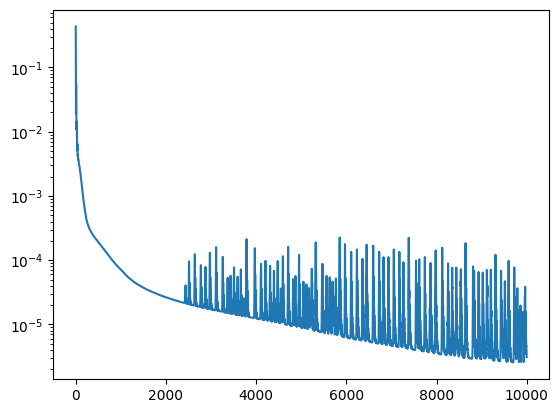

In [15]:
plt.semilogy(loss_history)

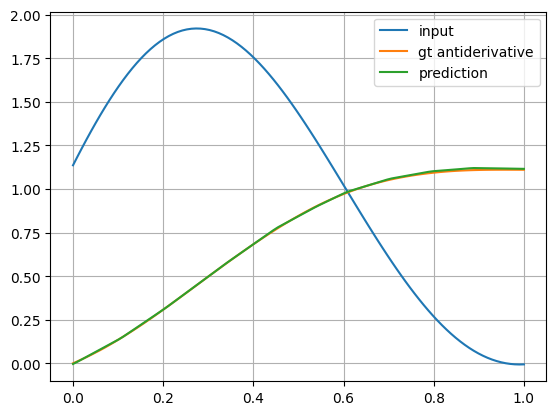

In [16]:
plt.plot(
    trunk_inputs_test[:, 0],
    branch_inputs_test[0, :],
    label="input",
)
plt.plot(
    trunk_inputs_test[:, 0],
    outputs_test[0, :],
    label="gt antiderivative",
)
plt.plot(
    trunk_inputs_test[:, 0],
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    )(branch_inputs_test[0, :], trunk_inputs_test),
    label="prediction",
)
plt.legend()
plt.grid()

In [17]:
predictions_test = jax.vmap(
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    ),
    in_axes=(0, None,)
)(branch_inputs_test, trunk_inputs_test)

In [18]:
predictions_test.shape

(1000, 100)

In [19]:
def normalized_l2_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

In [23]:
test_errors = jax.vmap(normalized_l2_error)(predictions_test, outputs_test)

In [24]:
mean_test_error = jnp.mean(test_errors)
std_test_error = jnp.std(test_errors)

In [25]:
mean_test_error, std_test_error

(Array(0.01071699, dtype=float32), Array(0.02059094, dtype=float32))